# Exploring TAD peak binding logic

## Import libraries/functions

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r'\boldmath \usepackage{amsmath} \usepackage{amssymb}'
from matplotlib.pyplot import cm

import scipy

import itertools
from collections import Counter

import gc

## Import data

In [2]:
data_dir = '../data'

atac_file = 'ATACseq-CQN-preprocessed-norm-counts.tsv'
rna_file  = 'RNAseq-DEseq2-preprocessed-norm-counts.tsv'

# TAD boundaries #
tad_file = 'TADs-interTADs_mESC.Bonev_2017.bed'

In [3]:
# -- load atac peak counts -- #
atac_df = pd.read_csv(data_dir+'/'+atac_file, sep='\t')
print(atac_df.shape)

# !!! NOTE THIS STEP !!!
# remove peaks overlapping with exons
bool_exon = atac_df['context'] != 'exon'
atac_df = atac_df[:][bool_exon]
# !!! NOTE THIS STEP !!!


# add peak width as features
atac_df['peak-width'] = atac_df['chromEnd'] - atac_df['chromStart']

print(atac_df.shape)
print(atac_df.columns)

atac_df['chromEnd'] = atac_df['chromEnd'].astype(int)
atac_df['chromStart'] = atac_df['chromStart'].astype(int)

(361867, 14)
(333960, 15)
Index(['Unnamed: 0', 'D0', 'D1', 'D2', 'D3', 'D5_GFPminus', 'D5_GFPplus',
       'chrom', 'chromStart', 'chromEnd', 'context', 'nearest_gene_ensemble',
       'nearest_gene_id', 'tad-id-bonev', 'peak-width'],
      dtype='object')


In [4]:
## compute atac-seq fold changes ##
log2fc_13   = atac_df['D3'] - atac_df['D1']
log2fc_35m  = atac_df['D5_GFPminus'] - atac_df['D3']
log2fc_35p  = atac_df['D5_GFPplus'] - atac_df['D3']
log2fc_5p5m = atac_df['D5_GFPplus'] - atac_df['D5_GFPminus']

In [5]:
## ---------------------  ##
## -- load RNAseq data -- ##
## ---------------------- ##
rna_df = pd.read_csv(data_dir+'/'+rna_file, sep='\t')

rna_df['day0'] = rna_df[['Day0_1','Day0_2','Day0_3']].mean(axis=1)
rna_df['day1'] = rna_df[['Day1_1','Day1_2','Day1_3']].mean(axis=1)
rna_df['day2'] = rna_df[['Day2_1','Day2_2','Day2_3']].mean(axis=1)
rna_df['day3'] = rna_df[['Day3_1','Day3_2','Day3_3']].mean(axis=1)
rna_df['day4-gfpneg'] = rna_df[['Day4_GFPneg_1','Day4_GFPneg_2','Day4_GFPneg_3']].mean(axis=1)
rna_df['day4-gfppos'] = rna_df[['Day4_GFPpos_1','Day4_GFPpos_2','Day4_GFPpos_3']].mean(axis=1)
rna_df['day5-gfpneg'] = rna_df[['Day5_GFPneg_1','Day5_GFPneg_2','Day5_GFPneg_3']].mean(axis=1)
rna_df['day5-gfppos'] = rna_df[['Day5_GFPpos_1','Day5_GFPpos_2','Day5_GFPpos_3']].mean(axis=1)

print(rna_df.columns, rna_df.shape)

Index(['Unnamed: 0', 'ext_gene', 'ens_gene', 'chrom', 'chromStart', 'chromEnd',
       'strand', 'Day0_1', 'Day0_2', 'Day0_3', 'Day1_1', 'Day1_2', 'Day1_3',
       'Day2_1', 'Day2_2', 'Day2_3', 'Day3_1', 'Day3_2', 'Day3_3',
       'Day4_GFPneg_1', 'Day4_GFPneg_2', 'Day4_GFPneg_3', 'Day4_GFPpos_1',
       'Day4_GFPpos_2', 'Day4_GFPpos_3', 'Day5_GFPneg_1', 'Day5_GFPneg_2',
       'Day5_GFPneg_3', 'Day5_GFPpos_1', 'Day5_GFPpos_2', 'Day5_GFPpos_3',
       'EF-up', 'EF-down', 'D0-D1-up', 'D0-D1-down', 'D1-D2-up', 'D1-D2-down',
       'D2-D3-up', 'D2-D3-down', 'HK', 'tad-id-bonev', 'day0', 'day1', 'day2',
       'day3', 'day4-gfpneg', 'day4-gfppos', 'day5-gfpneg', 'day5-gfppos'],
      dtype='object') (49705, 49)


In [6]:
## ---------------------- ##
## -- load tobias data -- ##
## ---------------------- ##
pval_select = '5em4'
if pval_select == '1em4':
    tobias_data_dir = '/home/andrew/biology/xdf/rotation3/mammalian_eftfs/data/tobias/footprint_score_files'
elif pval_select == '5em4':
    tobias_data_dir = '/home/andrew/biology/xdf/rotation3/mammalian_eftfs/data/tobias'


tobias_timecourse_d1_scores_file     = 'tobias_timecourse_D1_footprint_scores.csv'
tobias_timecourse_d2_scores_file     = 'tobias_timecourse_D2_footprint_scores.csv'
tobias_timecourse_d3_scores_file     = 'tobias_timecourse_D3_footprint_scores.csv'
tobias_timecourse_d5plus_scores_file = 'tobias_timecourse_D5_GFPplus_footprint_scores.csv'

## load
tobias_timecourse_d1_scores = pd.read_csv(tobias_data_dir+'/'+tobias_timecourse_d1_scores_file)
tobias_timecourse_d1_scores = tobias_timecourse_d1_scores.drop(columns=['Unnamed: 0'])
tobias_timecourse_d2_scores = pd.read_csv(tobias_data_dir+'/'+tobias_timecourse_d2_scores_file)
tobias_timecourse_d2_scores = tobias_timecourse_d2_scores.drop(columns=['Unnamed: 0'])
tobias_timecourse_d3_scores = pd.read_csv(tobias_data_dir+'/'+tobias_timecourse_d3_scores_file)
tobias_timecourse_d3_scores = tobias_timecourse_d3_scores.drop(columns=['Unnamed: 0'])
tobias_timecourse_d5plus_scores = pd.read_csv(tobias_data_dir+'/'+tobias_timecourse_d5plus_scores_file)
tobias_timecourse_d5plus_scores = tobias_timecourse_d5plus_scores.drop(columns=['Unnamed: 0'])

## remove peaks overlapping with exons
tobias_timecourse_d1_scores = tobias_timecourse_d1_scores[:][bool_exon]
tobias_timecourse_d2_scores = tobias_timecourse_d2_scores[:][bool_exon]
tobias_timecourse_d3_scores = tobias_timecourse_d3_scores[:][bool_exon]
tobias_timecourse_d5plus_scores = tobias_timecourse_d5plus_scores[:][bool_exon]

motif_columns = tobias_timecourse_d3_scores.columns[1:].tolist()

In [7]:
motifs_of_interest = ['Rax_2_M00426_2.00', 'Rax_PH0156.1',
                      'Pax6_2_M00540_2.00', 'Pax6_PH0132.1',
                      'Lhx2_2_M00380_2.00', 'Lhx2_PH0092.1',
                      'Sox2_1_MA0143.2', 'Sox2_2_MA0143.1', 'Sox2_3_M08041_2.00', 'Sox2_MA0143.3',
                      'Pou5f1Sox2_MA0142.1',
                      'Otx2_PH0130.1', 'Otx2_2_M00418_2.00',
                     ]

In [8]:
candidates_target_peaks    = ['chr18:65941112-65941777',  # Rax element (Danno)
                              'chr12:72852284-72852711',  # Six6 element
                             ]

candidates_other_peaks     = ['chr18:66015368-66015901', # candidate Rax element
                              'chr18:66019946-66020128', # candidate Rax element
                              'chr18:66022619-66023658', # candidate Rax element
                              'chr12:72854413-72854757', # candidate Six6 element
                             ]

ef_genes_transcription_dir = {'Rax':'-',
                              'Pax6':'+',
                              'Six3':'+',
                              'Six6':'+',
                              'Lhx2':'+'}

## Peak exploration

In [9]:
gene_select = 'Rax'
#gene_select = 'Six6'
#gene_select = 'Pax6'
#gene_select = 'Lhx2'
#gene_select = 'Six3'
gene_tad    = rna_df['tad-id-bonev'][rna_df['ext_gene'] == gene_select].values[0]

bool_peaks_tad = atac_df['tad-id-bonev'] == gene_tad
print('Gene:  ',gene_select)
print('TAD id:', gene_tad)
print('# peaks in TAD:', bool_peaks_tad.sum())


###### compute peak-gene distances ###
if ef_genes_transcription_dir[gene_select] == '+':
    
    gene_select_tss = rna_df['chromStart'][rna_df['ext_gene'] == gene_select].values[0]
    
elif ef_genes_transcription_dir[gene_select] == '-':
    
    gene_select_tss = rna_df['chromEnd'][rna_df['ext_gene'] == gene_select].values[0]
print('Gene TSS:', gene_select_tss)

## for visualization, restrict to peaks within TAD or peaks < 150kb from TSS ##
peak_select_midpoints = 0.5*(atac_df['chromStart'] +
                             atac_df['chromEnd'])

peak_gene_distances = np.abs((peak_select_midpoints.values - gene_select_tss))/1000 # units: kb

bool_peaks_tad = bool_peaks_tad & (peak_gene_distances < 150)
print('Peaks within TAD and closer than 150kb:', bool_peaks_tad.sum())

bool_candidate_peaks = []
bool_other_candidate_peaks = []
for j in range(bool_peaks_tad.sum()):
    
    tmp_peak_str = atac_df['chrom'][bool_peaks_tad].iloc[j] + ':' \
                 + atac_df['chromStart'][bool_peaks_tad].iloc[j].astype(str) + '-' \
                 + atac_df['chromEnd'][bool_peaks_tad].iloc[j].astype(str)
    bool_candidate_peaks.append(tmp_peak_str in candidates_target_peaks)
    bool_other_candidate_peaks.append(tmp_peak_str in candidates_other_peaks)
        
## generate differences in footprint scores ##
diff_binding_d3d1_df = tobias_timecourse_d3_scores[motifs_of_interest][bool_peaks_tad] \
                     - tobias_timecourse_d1_scores[motifs_of_interest][bool_peaks_tad]
diff_binding_d3d1_vals = diff_binding_d3d1_df.values
#
diff_binding_df = tobias_timecourse_d5plus_scores[motifs_of_interest][bool_peaks_tad] \
                - tobias_timecourse_d3_scores[motifs_of_interest][bool_peaks_tad]
peak_ids = diff_binding_df.index.tolist()
diff_binding_vals = diff_binding_df.values

## log2fc atac for peak selection
atac_fc_d5d3  = log2fc_35p[bool_peaks_tad].values
atac_fc_d5d5m = log2fc_5p5m[bool_peaks_tad].values
atac_fc_d3d1  = log2fc_13[bool_peaks_tad].values

Gene:   Rax
TAD id: 3499
# peaks in TAD: 26
Gene TSS: 65939787
Peaks within TAD and closer than 150kb: 26


/home/andrew/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


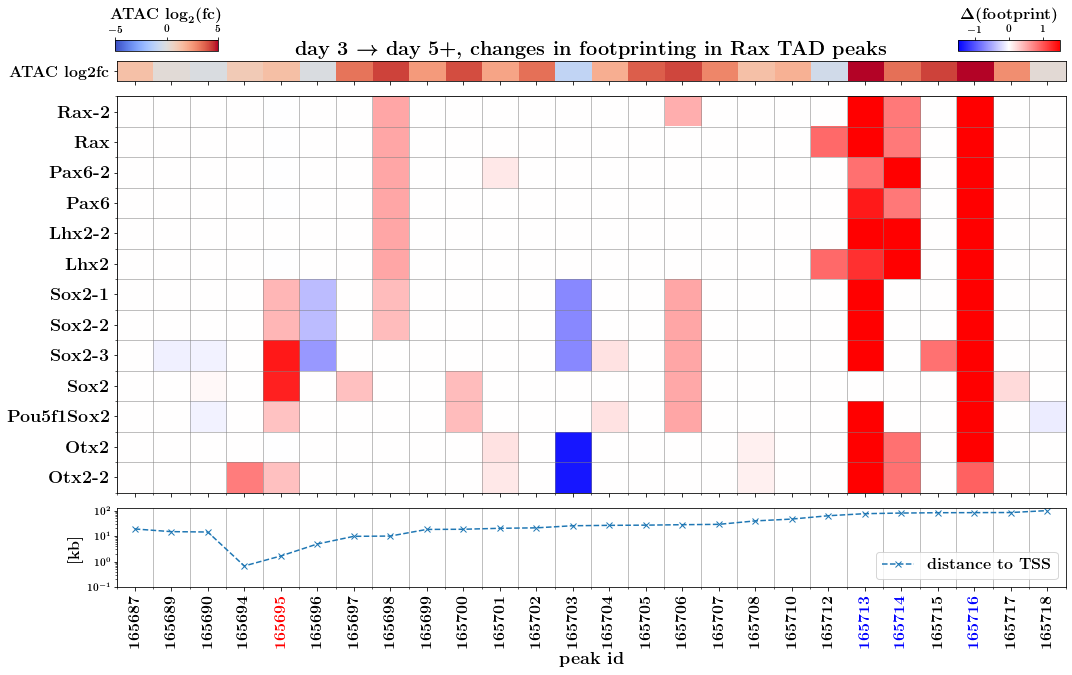

In [10]:
### --------------------- ###
### make day3 > day5 plot ###
### --------------------- ###
fig, axs = plt.subplots(3,1,figsize=(15,9),gridspec_kw={'height_ratios': [0.5,10,2]})
axs = axs.ravel()

motif_labels_pre = [r'\bf '+motif.replace('_','-') for motif in motifs_of_interest]
motif_labels = []
for motif in motif_labels_pre:    
    if len(motif.split('-')) == 2:
        motif_labels.append(motif.split('-')[0])
    elif len(motif.split('-')) > 2:
        motif_labels.append('-'.join(motif.split('-')[:2]))
peak_labels  = [r'\bf '+str(peak) for peak in peak_ids]

## ---------------------- ##
## panel 1: ATACseq logfc ##
## ---------------------- ##
im1 = axs[0].imshow(atac_fc_d5d3.reshape((bool_peaks_tad.sum(),1)).T,
              vmin=-5,vmax=5,cmap='coolwarm',aspect='auto')
axs[0].set_yticks([0])
axs[0].set_yticklabels([r'\bf ATAC log2fc'],fontsize=16)
axs[0].set_xticks(range(len(peak_ids)))
axs[0].set_xticklabels([])

## ------------------------------------- ##
## panel 2: change in motif footprinting ##
## ------------------------------------- ##
im2 = axs[1].imshow(diff_binding_vals.T,vmin=-1.5,vmax=1.5,cmap='bwr',aspect='auto')
axs[1].set_yticks(range(len(motifs_of_interest)))
axs[1].set_yticklabels(motif_labels,fontsize=18)
axs[1].set_xticks(range(len(peak_ids)))
axs[1].set_xticklabels([])
# minor ticks
axs[1].set_yticks(np.arange(-.5, len(motifs_of_interest), 1), minor=True)
axs[1].set_xticks(np.arange(-.5, len(peak_ids), 1), minor=True)

# Gridlines based on minor ticks
axs[1].grid(which='minor', color='Gray', linestyle='-', linewidth=0.5)
    
## -------------------------------- ##
## panel 2: distance of peak to TSS ##
## -------------------------------- ##
axs[2].plot(range(len(peak_ids)),peak_gene_distances[bool_peaks_tad],'x--',label=r'\bf distance to TSS')
axs[2].set_ylabel(r'\bf [kb]',fontsize=16)
axs[2].set_xlabel(r'\bf peak id',fontsize=18)
axs[2].set_yscale('log')
axs[2].set_xticks(range(len(peak_ids)))
axs[2].set_xticklabels(peak_labels,rotation=90,fontsize=16)
axs[2].set_xticks(np.arange(-.5, len(peak_ids), 1), minor=True)
axs[2].legend(loc='lower right',fontsize=16)

# Gridlines based on minor ticks
axs[2].grid(which='minor', color='Gray', axis='x', linestyle='-', linewidth=0.5)
axs[2].set_xlim(axs[1].get_xlim())
axs[2].set_ylim(1e-1,)

axs[0].set_title(r'\bf day 3 $\to$ day 5+, changes in footprinting in '+gene_select+' TAD peaks',fontsize=20)

candidate_peaks_idx = np.where(bool_candidate_peaks)[0]
for jj in candidate_peaks_idx:
    axs[2].get_xticklabels()[jj].set_color('Red')
    
candidate_other_peaks_idx = np.where(bool_other_candidate_peaks)[0]
for jj in candidate_other_peaks_idx:
    axs[2].get_xticklabels()[jj].set_color('Blue')

## add color bars ##
cbar_height = axs[0].get_position().height *0.6
cax = fig.add_axes([#axs[0].get_position().x1-.120,
                    axs[0].get_position().x0-.015,
                    axs[0].get_position().y1+0.089,0.095,
                    cbar_height])
cbar = plt.colorbar(im1, cax=cax, orientation='horizontal',ticklocation='top') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(r'\bf ATAC $ \log_2(\text{fc})$', fontsize=16, labelpad=6)

cax2 = fig.add_axes([axs[0].get_position().x1-.010,
                     axs[0].get_position().y1+0.089,0.095,
                     cbar_height])
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal',ticklocation='top') # Similar to fig.colorbar(im, cax = cax)
cbar2.set_label(r'\bf $\Delta(\text{footprint})$', fontsize=16, labelpad=6)
## add color bars ##

plt.tight_layout()
#file_str='08_tad_peak_35p_footprint_differences_'+gene_select+'.pdf'
#print(file_str)
#plt.savefig('./figures_paper/'+file_str,bbox_inches='tight')
plt.show()

/home/andrew/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


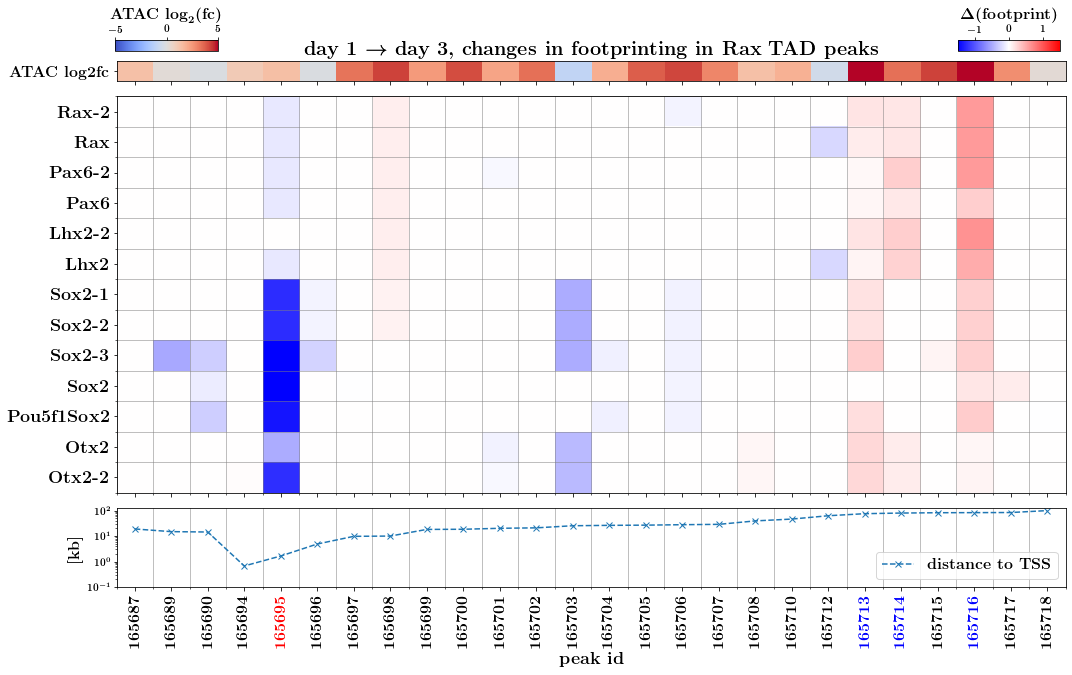

In [11]:
### --------------------- ###
### make day1 > day3 plot ###
### --------------------- ###
fig, axs = plt.subplots(3,1,figsize=(15,9),gridspec_kw={'height_ratios': [0.5,10,2]})
axs = axs.ravel()

motif_labels_pre = [r'\bf '+motif.replace('_','-') for motif in motifs_of_interest]
motif_labels = []
for motif in motif_labels_pre:    
    if len(motif.split('-')) == 2:
        motif_labels.append(motif.split('-')[0])
    elif len(motif.split('-')) > 2:
        motif_labels.append('-'.join(motif.split('-')[:2]))
peak_labels  = [r'\bf '+str(peak) for peak in peak_ids]

## ---------------------- ##
## panel 1: ATACseq logfc ##
## ---------------------- ##
im1 = axs[0].imshow(atac_fc_d5d3.reshape((bool_peaks_tad.sum(),1)).T,
              vmin=-5,vmax=5,cmap='coolwarm',aspect='auto')
axs[0].set_yticks([0])
axs[0].set_yticklabels([r'\bf ATAC log2fc'],fontsize=16)
axs[0].set_xticks(range(len(peak_ids)))
axs[0].set_xticklabels([])

## ------------------------------------- ##
## panel 2: change in motif footprinting ##
## ------------------------------------- ##
im2 = axs[1].imshow(diff_binding_d3d1_vals.T,vmin=-1.5,vmax=1.5,cmap='bwr',aspect='auto')
axs[1].set_yticks(range(len(motifs_of_interest)))
axs[1].set_yticklabels(motif_labels,fontsize=18)
axs[1].set_xticks(range(len(peak_ids)))
axs[1].set_xticklabels([])
# minor ticks
axs[1].set_yticks(np.arange(-.5, len(motifs_of_interest), 1), minor=True)
axs[1].set_xticks(np.arange(-.5, len(peak_ids), 1), minor=True)

# Gridlines based on minor ticks
axs[1].grid(which='minor', color='Gray', linestyle='-', linewidth=0.5)
    
## -------------------------------- ##
## panel 2: distance of peak to TSS ##
## -------------------------------- ##
axs[2].plot(range(len(peak_ids)),peak_gene_distances[bool_peaks_tad],'x--',label=r'\bf distance to TSS')
axs[2].set_ylabel(r'\bf [kb]',fontsize=16)
axs[2].set_xlabel(r'\bf peak id',fontsize=18)
axs[2].set_yscale('log')
axs[2].set_xticks(range(len(peak_ids)))
axs[2].set_xticklabels(peak_labels,rotation=90,fontsize=16)
axs[2].set_xticks(np.arange(-.5, len(peak_ids), 1), minor=True)
axs[2].legend(loc='lower right',fontsize=16)

# Gridlines based on minor ticks
axs[2].grid(which='minor', color='Gray', axis='x', linestyle='-', linewidth=0.5)
axs[2].set_xlim(axs[1].get_xlim())
axs[2].set_ylim(1e-1,)

axs[0].set_title(r'\bf day 1 $\to$ day 3, changes in footprinting in '+gene_select+' TAD peaks',fontsize=20)

candidate_peaks_idx = np.where(bool_candidate_peaks)[0]
for jj in candidate_peaks_idx:
    axs[2].get_xticklabels()[jj].set_color('Red')
    
candidate_other_peaks_idx = np.where(bool_other_candidate_peaks)[0]
for jj in candidate_other_peaks_idx:
    axs[2].get_xticklabels()[jj].set_color('Blue')

## add color bars ##
cbar_height = axs[0].get_position().height *0.6
cax = fig.add_axes([axs[0].get_position().x0-.015,
                    axs[0].get_position().y1+0.089,0.095,
                    cbar_height])
cbar = plt.colorbar(im1, cax=cax, orientation='horizontal',ticklocation='top') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(r'\bf ATAC $ \log_2(\text{fc})$', fontsize=16, labelpad=6)

cax2 = fig.add_axes([axs[0].get_position().x1-.010,
                     axs[0].get_position().y1+0.089,0.095,
                     cbar_height])
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal',ticklocation='top') # Similar to fig.colorbar(im, cax = cax)
cbar2.set_label(r'\bf $\Delta(\text{footprint})$', fontsize=16, labelpad=6)
## add color bars ##

plt.tight_layout()
#file_str='08_tad_peak_13_footprint_differences_'+gene_select+'.pdf'
#print(file_str)
#plt.savefig('./figures_paper/'+file_str,bbox_inches='tight')
plt.show()